# prac 4: Stock Price Forecasting

# Log diagram
graph TD
    A(Bắt đầu) --> B[1. Tải Thư viện];
    B --> C[2. Tải Dữ liệu (yfinance AAPL)];
    C --> D[3. Tiền xử lý Dữ liệu];
    D --> E(Chia Train/Val/Test);
    E --> F(Chuẩn hóa (Scale) Dữ liệu);
    F --> G(Tạo Dữ liệu Dạng Chuỗi (Sequences));
    
    G --> H{Huấn luyện Song song};

    subgraph "Mô hình 1: LSTM"
        H --> I[4a. Xây dựng mô hình LSTM];
        I --> J(Compile LSTM);
        J --> K(Fit/Train LSTM);
    end

    subgraph "Mô hình 2: CNN"
        H --> L[4b. Xây dựng mô hình CNN];
        L --> M(Compile CNN);
        M --> N(Fit/Train CNN);
    end

    K --> O[5. Đánh giá 2 mô hình];
    N --> O;
    
    O --> P(Tính toán RMSE & MAE);
    P --> Q[6. Trực quan hóa Kết quả];
    Q(Vẽ biểu đồ so sánh Actual vs. LSTM vs. CNN);
    
    Q --> R[7. Mở rộng: Dự báo Đa bước];
    R(Dùng LSTM dự đoán 5 ngày tới);
    R --> S(Kết thúc);

step 0: libraries

In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D,GlobalAveragePooling1D,BatchNormalization, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import datetime

# bỏ qua cảnh báo
import warnings
warnings.filterwarnings("ignore")

step 1: load the stock data(yahoo finance)

In [32]:
# ký hiệu chứng khoán cho dữ liệu Apple
tickers = 'AAPL'

# down dữ liệu từ Yahoo Finance
data = yf.download(tickers, start='2010-01-01', end=datetime.datetime.now().strftime('%Y-%m-%d'))
print(data.head(5))


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.424604  6.439314  6.375671  6.407192  493729600
2010-01-05  6.435714  6.472038  6.401791  6.442318  601904800
2010-01-06  6.333344  6.461229  6.326739  6.435712  552160000
2010-01-07  6.321636  6.364265  6.275706  6.356760  477131200
2010-01-08  6.363665  6.364265  6.276007  6.313231  447610800


step 2: Preprocess and scale the data

In [33]:
# dùng cột "Close" để dự đoán
data = data[['Close']]

In [34]:
# chuẩn hóa dữ liệu (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))

In [35]:
# chia  train và test
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

train_raw = data.iloc[:train_size]
val_raw = data.iloc[train_size : train_size + val_size]
test_raw = data.iloc[train_size + val_size :]

scaler.fit(train_raw[['Close']])               # FIT only on train
train_scaled = scaler.transform(train_raw)
val_scaled = scaler.transform(val_raw)
test_scaled  = scaler.transform(test_raw)

In [36]:
# tạo dữ liệu chuỗi thời gian
def create_sequences(data, time_steps=60,horizon=1):
    X, y = [], []
    for i in range(len(data) - time_steps - (horizon+1)):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps + (horizon - 1), 0])
    return np.array(X), np.array(y)

time_steps = 60
horizon = 1
x_train, y_train = create_sequences(train_scaled, time_steps = 60, horizon = 1)
x_test, y_test = create_sequences(test_scaled, time_steps = 60, horizon = 1)

In [ ]:
# Tạo x_val và y_val từ val_scaled
x_val, y_val = create_sequences(val_scaled, time_steps)

# Reshape x_val cho mô hình 
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))

# định dạng input cho LSTM /CNN
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],1))

step 3: build&training LSTM model

In [38]:
# build
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])   

In [39]:
# compile
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [40]:
# training
model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0037 - mae: 0.0338 - val_loss: 0.0112 - val_mae: 0.0960
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 9.4567e-04 - mae: 0.0179 - val_loss: 0.0019 - val_mae: 0.0362
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 8.7536e-04 - mae: 0.0169 - val_loss: 0.0019 - val_mae: 0.0352
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 7.2141e-04 - mae: 0.0153 - val_loss: 0.0018 - val_mae: 0.0343
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 7.2776e-04 - mae: 0.0158 - val_loss: 0.0060 - val_mae: 0.0675
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 5.4965e-04 - mae: 0.0133 - val_loss: 0.0017 - val_mae: 0.0333
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 4.4245e-04 - mae: 0.0127 - val_loss: 0.0049 - val_mae: 0.0591
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 6.1012e-04 - mae: 0.0150 - val_loss: 0.0016 - val_mae: 0.0326
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━

step 4: build&training CNN model

In [41]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),


    Flatten(),
    
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

In [42]:
# compile
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [43]:
# training
cnn_model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0041 - mae: 0.0379 - val_loss: 0.0530 - val_mae: 0.2169
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mae: 0.0309 - val_loss: 0.0331 - val_mae: 0.1672
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mae: 0.0295 - val_loss: 0.0586 - val_mae: 0.2321
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - mae: 0.0256 - val_loss: 0.0597 - val_mae: 0.2346
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - mae: 0.0273 - val_loss: 0.0383 - val_mae: 0.1842
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mae: 0.0240 - val_loss: 0.0561 - val_mae: 0.2280
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mae: 0.0283 - val_loss: 0.0435 - val_mae: 0.1977
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mae: 0.0253 - val_loss: 0.0200 - val_mae: 0.1270
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - ma

step 5: evaluate model

In [44]:
def evaluate_model(model, X_test, y_test, scaler):
    pred = model.predict(X_test)
    pred_rescaled = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
    y_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    rmse = np.sqrt(mean_squared_error(y_rescaled, pred_rescaled))
    mae = mean_absolute_error(y_rescaled, pred_rescaled)
    return pred_rescaled, y_rescaled, rmse, mae

In [55]:
# Đánh giá LSTM
lstm_pred, y_true, lstm_rmse, lstm_mae = evaluate_model(model, x_test, y_test, scaler)
print(f"LSTM -> RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
LSTM -> RMSE: 8.2602, MAE: 6.4518


In [46]:
# Đánh giá CNN
cnn_pred, _, cnn_rmse, cnn_mae = evaluate_model(cnn_model, x_test, y_test, scaler)
print(f"CNN  -> RMSE: {cnn_rmse:.4f}, MAE: {cnn_mae:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
CNN  -> RMSE: 29.9709, MAE: 28.2747


step 6: visualize

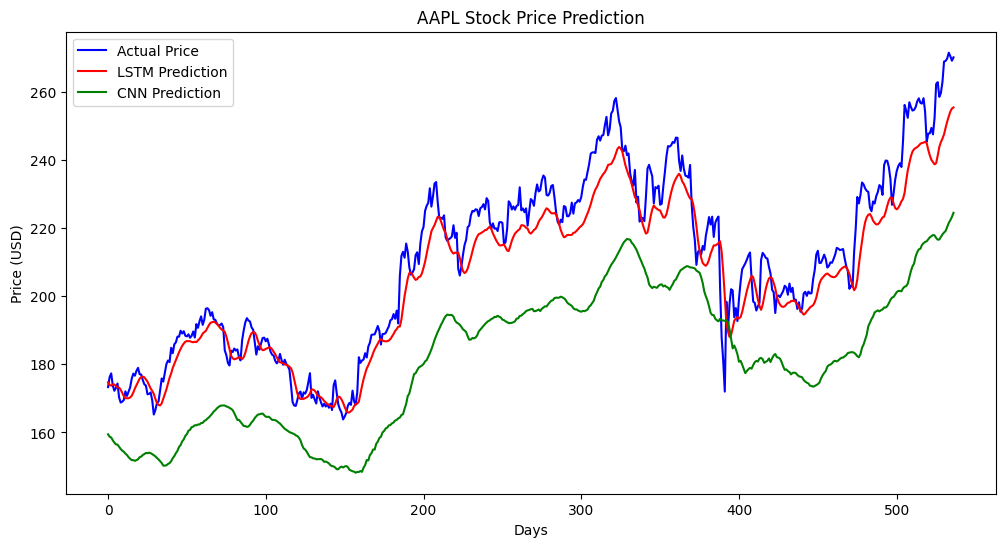

In [47]:
# biểu đồ kq
plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual Price', color='blue')
plt.plot(lstm_pred, label='LSTM Prediction', color='red')
plt.plot(cnn_pred, label='CNN Prediction', color='green')
plt.title(f'{tickers} Stock Price Prediction')
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

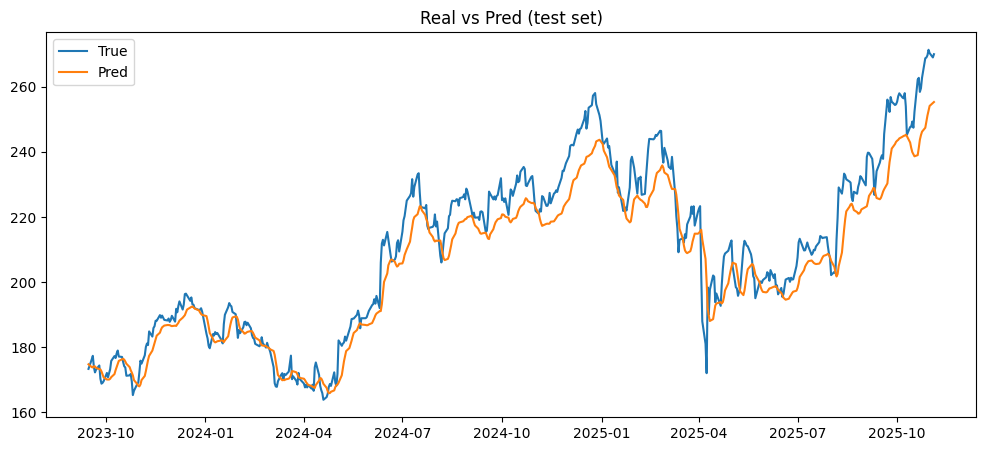

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(test_raw.index[60:60+len(y_true)], y_true, label='True')
plt.plot(test_raw.index[60:60+len(lstm_pred)], lstm_pred, label='Pred')
plt.legend()
plt.title('Real vs Pred (test set)')
plt.show()


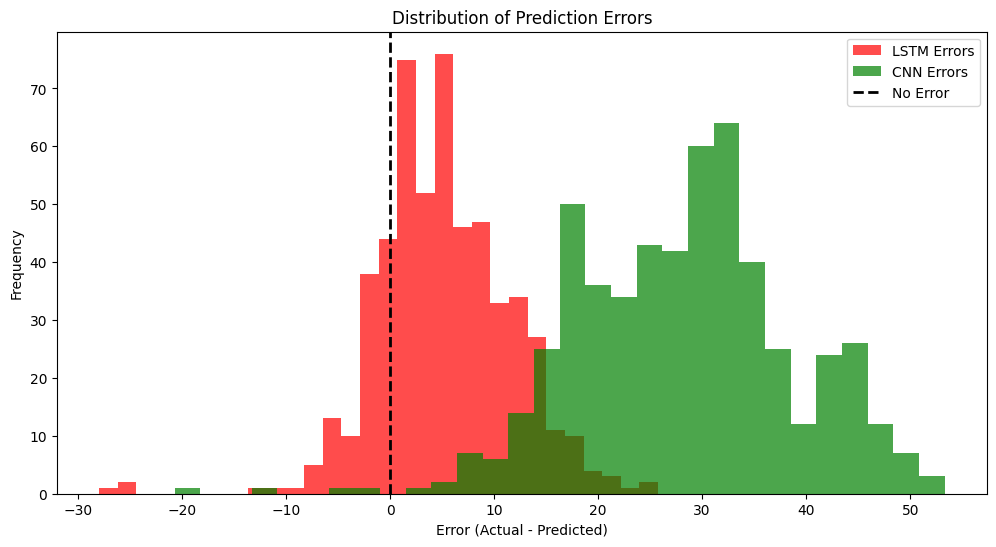

In [48]:
# Tính toán lỗi (errors)
errors_lstm = y_true - lstm_pred
errors_cnn = y_true - cnn_pred

# Vẽ biểu đồ phân phối lỗi
plt.figure(figsize=(12, 6))
plt.hist(errors_lstm, bins=30, alpha=0.7, label='LSTM Errors', color='red')
plt.hist(errors_cnn, bins=30, alpha=0.7, label='CNN Errors', color='green')

# Thêm đường 0 (lỗi = 0) để tham chiếu
plt.axvline(0, color='black', linestyle='--', linewidth=2, label='No Error')

plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Mở rộng: Multi-step Forecasting

In [49]:
def multi_step_forecast(model, data, n_days=5, time_steps=60):
    last_sequence = data[-time_steps:]
    preds = []
    seq = last_sequence.copy()
    for _ in range(n_days):
        pred = model.predict(seq.reshape(1, time_steps, 1))
        preds.append(pred[0, 0])
        seq = np.append(seq[1:], pred)
    return np.array(preds)


In [50]:
# Dự đoán 5 ngày tới bằng LSTM
future_preds = multi_step_forecast(model, test_scaled, n_days=5)
future_prices = scaler.inverse_transform(future_preds.reshape(-1, 1))

print("\n Dự đoán giá 5 ngày tới (LSTM):")
for i, price in enumerate(future_prices.flatten(), 1):
    print(f"Ngày {i}: ${price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

 Dự đoán giá 5 ngày tới (LSTM):
Ngày 1: $255.70
Ngày 2: $253.33
Ngày 3: $250.41
Ngày 4: $247.29
Ngày 5: $244.20
